<a href="https://colab.research.google.com/github/InduwaraGayashan001/PyTorch/blob/main/Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
!pip install -q torchinfo

In [2]:
import torch  # PyTorch core library for deep learning
import torch.nn as nn  # Neural network module in PyTorch
from torch.optim import Adam  # Adam optimizer for training models
import torch.nn.functional as F  # Functional interface for PyTorch layers
from torch.utils.data import DataLoader, Dataset  # Utilities for handling datasets and data loading
from torchinfo import summary  # Prints model architecture summary
from torch.utils.tensorboard import SummaryWriter  # Logging utility for TensorBoard

import torchvision  # PyTorch's library for image processing
from torchvision import datasets  # Datasets module for common image datasets
from torchvision.transforms import v2 as transforms  # Image transformation utilities
from torchvision.ops import Conv2dNormActivation  # Convolution layers with normalization and activation

from dataclasses import dataclass  # Data structure utility for structured storage
from sklearn.metrics import confusion_matrix  # Computes confusion matrix for classification
from sklearn.model_selection import train_test_split  # Splits dataset into training and testing sets
import seaborn as sn  # Data visualization library, often used for heatmaps

import matplotlib.pyplot as plt  # Visualization library for creating plots
import time  # Provides time-related functions
import numpy as np  # Library for numerical computing and array operations
import random  # Standard library module for generating random numbers
import warnings  # Handles warning messages
import os  # Provides functionalities for interacting with the operating system
from tqdm import tqdm  # Displays progress bars for loops

import pandas as pd  # Library for data manipulation and analysis
import random  # Included twice, can be removed if unnecessary
# Ensures inline plotting in Jupyter notebooks
%matplotlib inline
warnings.filterwarnings("ignore")  # Suppresses warning messages
#Set seed for reproducibilty
def set_seed(seed):
    random.seed(seed)  # Set the seed for Python's built-in random module
    np.random.seed(seed)  # Set the seed for NumPy's random number generator
    torch.manual_seed(seed)  # Set the seed for PyTorch's random number generator

    if torch.cuda.is_available():  # Check if a CUDA-enabled GPU is available
       torch.cuda.manual_seed(seed)  # Set the seed for CUDA (single GPU)
       torch.cuda.manual_seed_all(seed)  # Set the seed for CUDA (multiple GPUs)
       torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior for CuDNN
       torch.backends.cudnn.benchmark = True  # Enable benchmark mode for CuDNN (can improve performance)

set_seed(42)  # Set the random seed to 42 for reproducibility

# Extract Data

In [3]:
!wget -q "https://www.dropbox.com/s/45jdd8padeyjq6t/10_Monkey_Species.zip?dl=1" -O "10_Monkey_Species.zip"
!unzip -q "10_Monkey_Species.zip"

# Configurartion

In [4]:
@dataclass(frozen=True)
class TrainConfig:
  batch_size: int = 32
  num_epochs: int = 20
  learning_rate: float = 1e-4

  log_interval: int =1
  test_interval: int = 1
  data_root: int = "./"
  num_workers: int =5
  device: str = "cuda"

train_config = TrainConfig()

DEVICE = torch.device("cuda") if torch.cuda.is_available() else "cpu"

# Load Data

In [5]:
# Defining the path to the training dataset
train_root = os.path.join("10_Monkey_Species", "training", "training")  # Path to training data directory

# Defining the path to the validation dataset
val_root = os.path.join(train_config.data_root, "10_Monkey_Species", "validation", "validation")  # Path to validation data directory


In [6]:
df = pd.read_csv(os.path.join("10_Monkey_Species", "monkey_labels.txt"), sep=",", header=None)

# Assigning meaningful column names to the DataFrame
df.columns = ["Label", "Latin Name", "Common Name", "Train Images", "Validation Images"]

# Cleaning up the 'Latin Name' column by replacing tab characters with spaces
df['Latin Name'] = df['Latin Name'].str.replace("\t", " ")

# Displaying all rows except the first one
df[1:]

,Label,Latin Name,Common Name,Train Images,Validation Images
1,n0,alouatta_palliata,mantled_howler,131,26
2,n1,erythrocebus_patas,patas_monkey,139,28
3,n2,cacajao_calvus,bald_uakari,137,27
4,n3,macaca_fuscata,japanese_macaque,152,30
5,n4,cebuella_pygmea,pygmy_marmoset,131,26
6,n5,cebus_capucinus,white_headed_capuchin,141,28
7,n6,mico_argentatus,silvery_marmoset,132,26
8,n7,saimiri_sciureus,common_squirrel_monkey,142,28
9,n8,aotus_nigriceps,black_headed_night_monkey,133,27
10,n9,trachypithecus_johnii,nilgiri_langur,132,26


# Data Processing

In [7]:
# Mean and standard deviation values computed from the Monkey Species dataset
mean = [0.4368, 0.4336, 0.3294]  # Mean pixel values for normalization (RGB channels)
std = [0.2457, 0.2413, 0.2447]  # Standard deviation pixel values for normalization (RGB channels)

img_size =(224,224)

preprocess = transforms.Compose([
    transforms.Resize(img_size, antialias=True),
    transforms.ToTensor()
])

In [8]:
train_transforms = transforms.Compose([
    preprocess,
    transforms.RandomHorizontalFlip(),
    transforms.RandomErasing(p=0.4),
    transforms.RandomApply([
        transforms.RandomAffine(degrees=(30,70), translate=(0.1, 0.3), scale=(0.5, 0.75))
    ], p=0.1),
    transforms.Normalize(mean=mean, std=std)
])

val_transforms = transforms.Compose([
    preprocess,
    transforms.Normalize(mean=mean, std=std)
])

In [9]:
train_data = datasets.ImageFolder(root=train_root, transform=train_transforms)
val_data = datasets.ImageFolder(root=val_root, transform=val_transforms)

train_data.classes

['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']

In [10]:
train_data.class_to_idx

{'n0': 0,
 'n1': 1,
 'n2': 2,
 'n3': 3,
 'n4': 4,
 'n5': 5,
 'n6': 6,
 'n7': 7,
 'n8': 8,
 'n9': 9}

In [11]:
train_loader = DataLoader(
    train_data,
    batch_size=train_config.batch_size,
    shuffle=True,
    num_workers=train_config.num_workers,
)

val_loader = DataLoader(
    val_data,
    batch_size=train_config.batch_size,
    shuffle=False,
    num_workers=train_config.num_workers,
)

In [12]:
class_mapping = {

    0: "mantled_howler",
    1: "patas_monkey",
    2: "bald_uakari",
    3: "japanese_macaque",
    4: "pygmy_marmoset",
    5: "white_headed_capuchin",
    6: "silvery_marmoset",
    7: "common_squirrel_monkey",
    8: "black_headed_night_monkey",
    9: "nilgiri_langur"
}

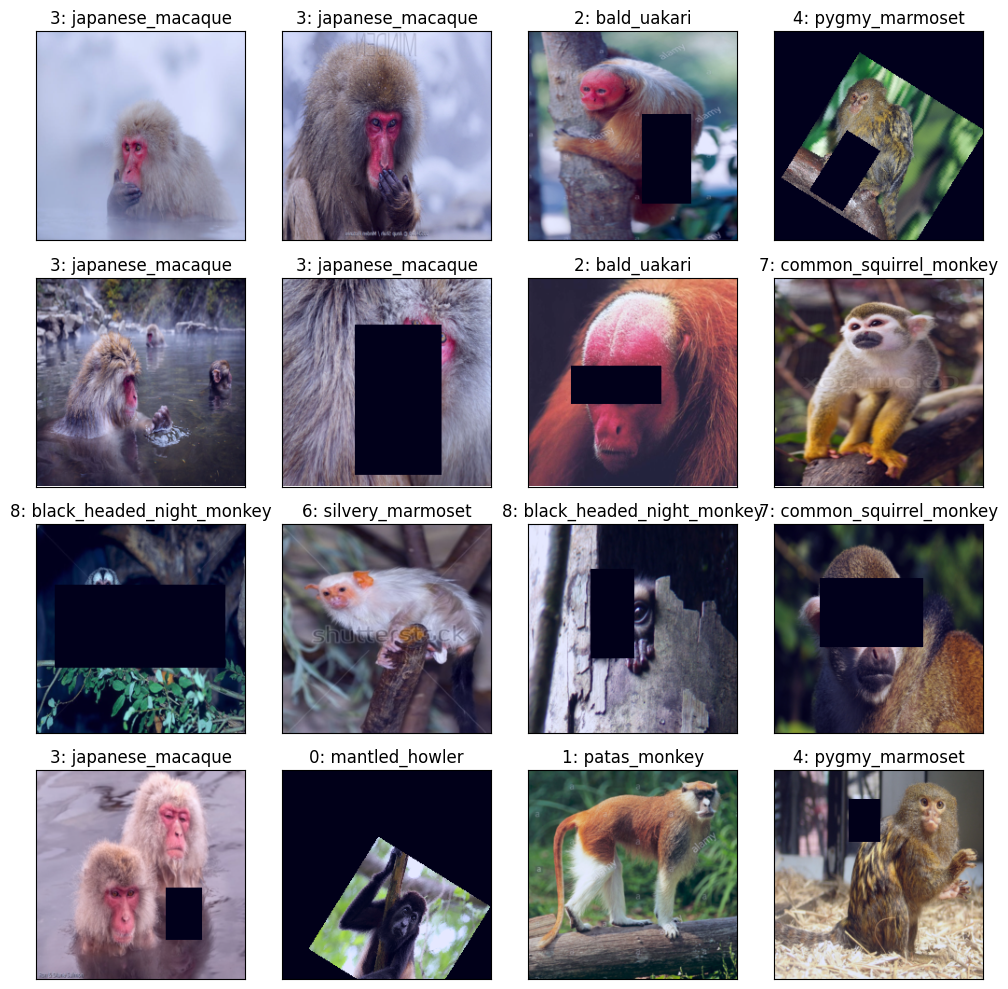

In [13]:
import matplotlib.pyplot as plt  # Importing Matplotlib for visualization
import numpy as np  # Importing NumPy for numerical operations

def visualize_images(dataloader, num_images=20):
    """
    Function to visualize a batch of images from the DataLoader.

    Parameters:
    dataloader (DataLoader): The PyTorch DataLoader containing image data.
    num_images (int): Number of images to visualize.
    """
    fig = plt.figure(figsize=(10, 10))  # Create a figure with a specified size

    # Retrieve the first batch from the DataLoader
    images, labels = next(iter(dataloader))

    num_rows = 4  # Define number of rows in the grid
    num_cols = int(np.ceil((num_images / num_rows)))  # Compute number of columns

    for idx in range(min(num_images, len(images))):  # Loop through the images up to num_images
        image, label = images[idx], labels[idx]  # Extract image and label

        ax = fig.add_subplot(num_rows, num_cols, idx + 1, xticks=[], yticks=[])  # Create subplot

        image = image.permute(1, 2, 0)  # Reorder dimensions for visualization (C, H, W) → (H, W, C)

        # Normalize the image to [0,1] for display
        image = (image - image.min()) / (image.max() - image.min())
        ax.imshow(image, cmap="gray")  # Display the image
        ax.set_title(f"{label.item()}: {class_mapping[label.item()]}")  # Set title with label info

    fig.tight_layout()  # Adjust layout for better spacing
    plt.show()  # Display the figure

# Call the function to visualize a sample of images from the training dataset
visualize_images(train_loader, num_images=16)

# FIne Tuning

In [14]:
from torchvision.models import mobilenet_v3_small

mobilenetv3_model = mobilenet_v3_small(weights="DEFAULT")

num_feature_layers = len(mobilenetv3_model.features)
num_classifier_layers = len(mobilenetv3_model.classifier)

print(f"Number of feature layers: {num_feature_layers}")
print(f"Number of classifier layers: {num_classifier_layers}")

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 60.4MB/s]

Number of feature layers: 13
Number of classifier layers: 4


In [15]:
for param in mobilenetv3_model.features[:10].parameters():
  param.requires_grad = False

In [16]:
print(mobilenetv3_model.classifier[3])

Linear(in_features=1024, out_features=1000, bias=True)


In [17]:
mobilenetv3_model.classifier[3] = nn.Linear(in_features=1024, out_features=10, bias=True)
print(mobilenetv3_model.classifier[3])

Linear(in_features=1024, out_features=10, bias=True)


In [18]:
model = mobilenetv3_model

optimizer = Adam(model.parameters(), lr=train_config.learning_rate)
DEVICE = torch.device("cuda") if torch.cuda.is_available() else "cpu"

logdir = "runs/mobilenetv3-Monkey-Species"

writer = SummaryWriter(logdir)

summary(model, input_size=(1, 3, 224, 224), row_settings=["var_names"],device="cpu")

Layer (type (var_name))                                      Output Shape              Param #
MobileNetV3 (MobileNetV3)                                    [1, 10]                   --
├─Sequential (features)                                      [1, 576, 7, 7]            --
│    └─Conv2dNormActivation (0)                              [1, 16, 112, 112]         --
│    │    └─Conv2d (0)                                       [1, 16, 112, 112]         (432)
│    │    └─BatchNorm2d (1)                                  [1, 16, 112, 112]         (32)
│    │    └─Hardswish (2)                                    [1, 16, 112, 112]         --
│    └─InvertedResidual (1)                                  [1, 16, 56, 56]           --
│    │    └─Sequential (block)                               [1, 16, 56, 56]           (744)
│    └─InvertedResidual (2)                                  [1, 24, 28, 28]           --
│    │    └─Sequential (block)                               [1, 24, 28, 28]           

# Training

In [19]:
import torch.nn.functional as F  # Importing functional API for loss computation
from tqdm import tqdm  # Importing tqdm for progress bar visualization


In [20]:
def train(model, train_loader):

  model.train()
  model.to(DEVICE)

  running_loss =0
  correct_predictions =0
  total_train_samples =0

  for images, labels in tqdm(train_loader, desc="Training"):
    images, labels  = images.to(DEVICE), labels.to(DEVICE)

    optimizer.zero_grad()

    outputs = model(images)

    loss = F.cross_entropy(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    _, preds = torch.max(outputs.data, dim=1)
    total_train_samples += labels.shape[0]
    correct_predictions +=(preds == labels).sum().item()

  train_loss = running_loss / len(train_loader)
  train_accuracy = 100* correct_predictions / total_train_samples

  return train_loss, train_accuracy

In [21]:
def validation(model, val_loader):

  model.eval()
  model.to(DEVICE)

  running_loss =0
  correct_predictions =0
  total_val_samples =0

  for images, labels in tqdm(val_loader, desc="Validation"):
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    with torch.no_grad():
      outputs = model(images)

    loss = F.cross_entropy(outputs, labels)

    running_loss += loss.item()
    _, preds = torch.max(outputs.data, dim=1)
    total_val_samples += labels.shape[0]
    correct_predictions +=(preds == labels).sum().item()

  val_loss = running_loss / len(val_loader)
  val_accuracy = 100* correct_predictions / total_val_samples

  return val_loss, val_accuracy

In [22]:
import torch

def main(model, train_loader, val_loader):

  train_losses, train_accuracies = [], []
  val_losses, val_accuracies = [], []

  best_val_acc =0
  best_weights = None

  for epoch in range(train_config.num_epochs):
    train_loss, train_accuracy = train(model, train_loader)
    val_loss, val_accuracy = validation(model, val_loader)


    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1:0>2}/{train_config.num_epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% - Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    writer.add_scalar("Loss/train", train_loss)
    writer.add_scalar("Loss/val", val_loss)
    writer.add_scalar("Accuracy/train", train_accuracy)
    writer.add_scalar("Accuracy/val", val_accuracy)

    if val_accuracy > best_val_acc:
      best_val_acc = val_accuracy
      best_weights = model.state_dict()
      torch.save(best_weights, "best.pt")


  return train_losses, train_accuracies, val_losses, val_accuracies


In [23]:
train_losses, train_accuracies, val_losses, val_accuracies = main(model, train_loader, val_loader)

Validation: 100%|██████████| 9/9 [00:05<00:00,  1.60it/s]


Epoch 01/20 - Train Loss: 2.0756, Train Accuracy: 33.00% - Val Loss: 1.5016, Val Accuracy: 66.54%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.48it/s]


Epoch 02/20 - Train Loss: 1.4599, Train Accuracy: 68.28% - Val Loss: 0.8675, Val Accuracy: 77.94%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]


Epoch 03/20 - Train Loss: 0.9788, Train Accuracy: 78.85% - Val Loss: 0.5115, Val Accuracy: 87.87%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.37it/s]


Epoch 04/20 - Train Loss: 0.6910, Train Accuracy: 82.41% - Val Loss: 0.3746, Val Accuracy: 92.28%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.65it/s]


Epoch 05/20 - Train Loss: 0.5189, Train Accuracy: 87.88% - Val Loss: 0.2897, Val Accuracy: 93.01%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.62it/s]


Epoch 06/20 - Train Loss: 0.4237, Train Accuracy: 87.88% - Val Loss: 0.2385, Val Accuracy: 94.49%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.60it/s]


Epoch 07/20 - Train Loss: 0.3374, Train Accuracy: 91.43% - Val Loss: 0.1992, Val Accuracy: 96.69%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.32it/s]


Epoch 08/20 - Train Loss: 0.3022, Train Accuracy: 92.07% - Val Loss: 0.1674, Val Accuracy: 95.96%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.31it/s]


Epoch 09/20 - Train Loss: 0.2933, Train Accuracy: 92.34% - Val Loss: 0.1476, Val Accuracy: 96.32%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.48it/s]


Epoch 10/20 - Train Loss: 0.2437, Train Accuracy: 92.53% - Val Loss: 0.1382, Val Accuracy: 95.59%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.64it/s]


Epoch 11/20 - Train Loss: 0.2341, Train Accuracy: 93.35% - Val Loss: 0.1274, Val Accuracy: 95.96%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.65it/s]


Epoch 12/20 - Train Loss: 0.2144, Train Accuracy: 93.80% - Val Loss: 0.1169, Val Accuracy: 97.06%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]


Epoch 13/20 - Train Loss: 0.1925, Train Accuracy: 93.80% - Val Loss: 0.1143, Val Accuracy: 96.32%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.35it/s]


Epoch 14/20 - Train Loss: 0.2092, Train Accuracy: 94.07% - Val Loss: 0.1113, Val Accuracy: 96.69%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.36it/s]


Epoch 15/20 - Train Loss: 0.1802, Train Accuracy: 94.44% - Val Loss: 0.1031, Val Accuracy: 97.06%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.63it/s]


Epoch 16/20 - Train Loss: 0.1806, Train Accuracy: 94.90% - Val Loss: 0.1004, Val Accuracy: 96.32%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.62it/s]


Epoch 17/20 - Train Loss: 0.1576, Train Accuracy: 94.99% - Val Loss: 0.0998, Val Accuracy: 96.69%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Epoch 18/20 - Train Loss: 0.1456, Train Accuracy: 95.72% - Val Loss: 0.1015, Val Accuracy: 97.06%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.34it/s]


Epoch 19/20 - Train Loss: 0.1361, Train Accuracy: 95.35% - Val Loss: 0.0952, Val Accuracy: 96.69%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.35it/s]

Epoch 20/20 - Train Loss: 0.1506, Train Accuracy: 94.99% - Val Loss: 0.0942, Val Accuracy: 96.69%


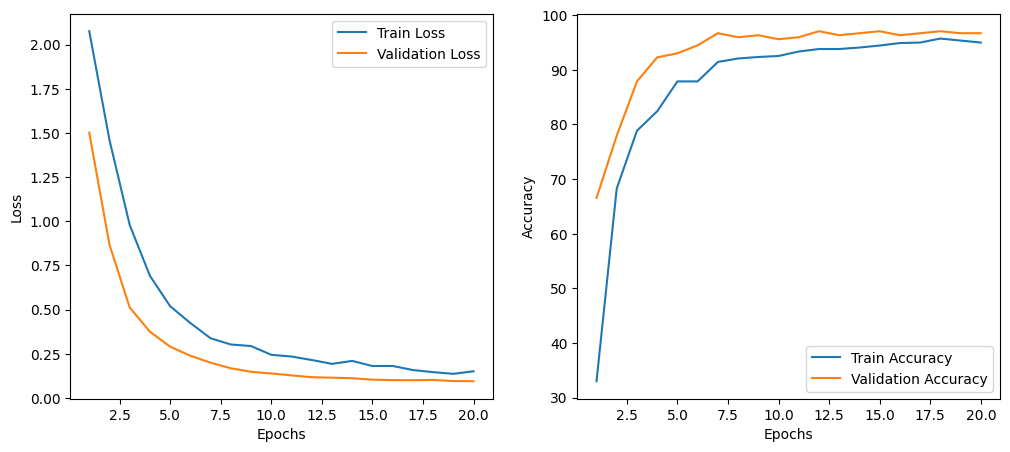

In [24]:
import matplotlib.pyplot as plt  # Importing Matplotlib for visualization

# Create a new figure with specified size
plt.figure(figsize=(12, 5))

# Plot training and validation loss over epochs
plt.subplot(1, 2, 1)  # Create subplot (1 row, 2 columns, 1st plot)
plt.plot(range(1, train_config.num_epochs + 1), train_losses, label="Train Loss")  # Plot train loss
plt.plot(range(1, train_config.num_epochs + 1), val_losses, label="Validation Loss")  # Plot validation loss
plt.xlabel("Epochs")  # Label for x-axis
plt.ylabel("Loss")  # Label for y-axis
plt.legend()  # Show legend to differentiate lines

# Plot training and validation accuracy over epochs
plt.subplot(1, 2, 2)  # Create subplot (1 row, 2 columns, 2nd plot)
plt.plot(range(1, train_config.num_epochs + 1), train_accuracies, label="Train Accuracy")  # Plot train accuracy
plt.plot(range(1, train_config.num_epochs + 1), val_accuracies, label="Validation Accuracy")  # Plot validation accuracy
plt.xlabel("Epochs")  # Label for x-axis
plt.ylabel("Accuracy")  # Label for y-axis
plt.legend()  # Show legend to differentiate lines

plt.show()  # Display the plots

# Save the Model

In [26]:
model.load_state_dict(torch.load("best.pt"))
model.eval()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

# Inference

In [35]:
def prediction(model, val_loader):
    """
    Generates predictions using the trained model on validation data.

    Parameters:
    model (torch.nn.Module): The trained neural network model.
    val_loader (DataLoader): The DataLoader for validation data.

    Returns:
    tuple: Arrays containing images, true labels, predicted labels, and prediction probabilities.
    """
    model.eval()  # Set the model to evaluation mode
    model.to(DEVICE)  # Move the model to the appropriate device (GPU/CPU)

    all_images, all_labels = [], []  # Lists to store images and true labels
    all_pred_indices, all_pred_probs = [], []  # Lists to store predicted labels and probabilities

    # Iterate over the validation dataset
    for images, labels in val_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)  # Move data to selected device

        with torch.inference_mode():  # Disable gradient calculations for efficiency
            outputs = model(images)  # Forward pass to get predictions

        prob = F.softmax(outputs, dim=1)  # Convert outputs to probabilities using softmax
        pred_indices = prob.data.max(dim=1)[1]  # Get predicted class index
        pred_probs = prob.data.max(dim=1)[0]  # Get corresponding prediction confidence

        all_images.append(images.cpu())  # Move images back to CPU and store
        all_labels.append(labels.cpu())  # Move labels back to CPU and store
        all_pred_indices.append(pred_indices.cpu())  # Store predicted indices
        all_pred_probs.append(pred_probs.cpu())  # Store predicted probabilities

    return (
        torch.cat(all_images).numpy(),  # Convert list of images to NumPy array
        torch.cat(all_labels).numpy(),  # Convert list of labels to NumPy array
        torch.cat(all_pred_indices).numpy(),  # Convert list of predicted labels to NumPy array
        torch.cat(all_pred_probs).numpy()  # Convert list of prediction probabilities to NumPy array
    )

In [36]:
def denormalize(image):
  mean_ar = np.array(mean)
  std_ar = np.array(std)
  image = image * std_ar + mean_ar
  return np.clip(image, 0,1)

In [37]:
def visualise_predictions(sample_images, sample_gt_labels, pred_indices, pred_probs, num_images=5):
    """
    Visualizes sample images along with their ground truth and predicted labels.

    Parameters:
    sample_images (numpy.ndarray): Array of sample images.
    sample_gt_labels (numpy.ndarray): Ground truth labels for the images.
    pred_indices (numpy.ndarray): Predicted class indices.
    pred_probs (numpy.ndarray): Prediction probabilities.
    num_images (int): Number of images to visualize.
    """
    fig = plt.figure(figsize=(20, 5))  # Create a figure with specified size

    for i in range(num_images):
        idx = random.randint(0, len(sample_images) - 1)  # Select a random index
        image = sample_images[idx].transpose(1, 2, 0)  # Convert (C,H,W) to (H,W,C) for display
        label = sample_gt_labels[idx]  # Get the ground truth label
        pred_idx = pred_indices[idx]  # Get the predicted class index
        pred_prob = pred_probs[idx]  # Get the corresponding prediction confidence

        image = denormalize(image)  # Denormalize the image for proper visualization

        ax = fig.add_subplot(1, num_images, i + 1)  # Create a subplot
        ax.imshow(image)  # Display the image
        ax.set_title(f"GT: {class_mapping[label]}\nPred: {class_mapping[pred_idx]} ({pred_prob:.2f})")  # Set title
        ax.axis('off')  # Remove axis labels for better display

    plt.show()  # Display the figure

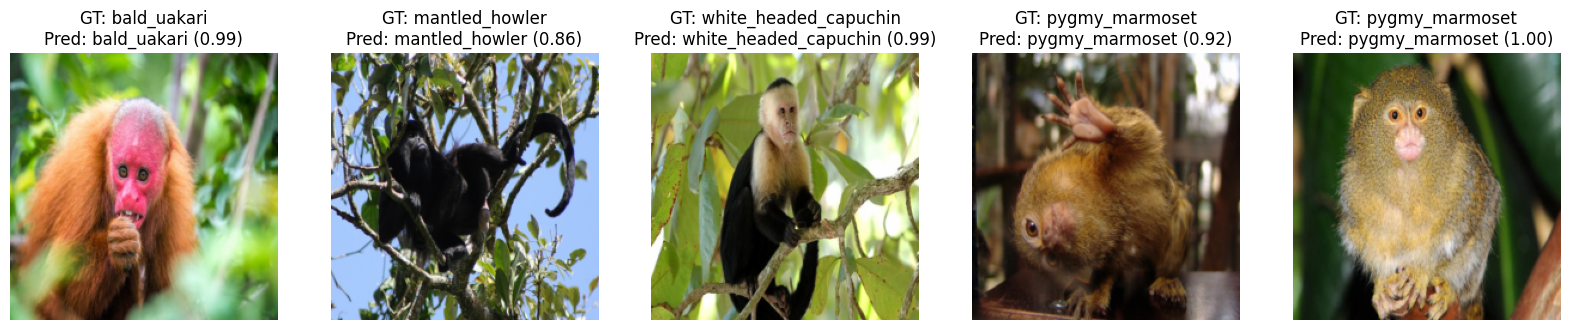

In [38]:
val_images, val_gt_labels , pred_indices, pred_probs = prediction(model, val_loader)
visualise_predictions(val_images, val_gt_labels, pred_indices, pred_probs)

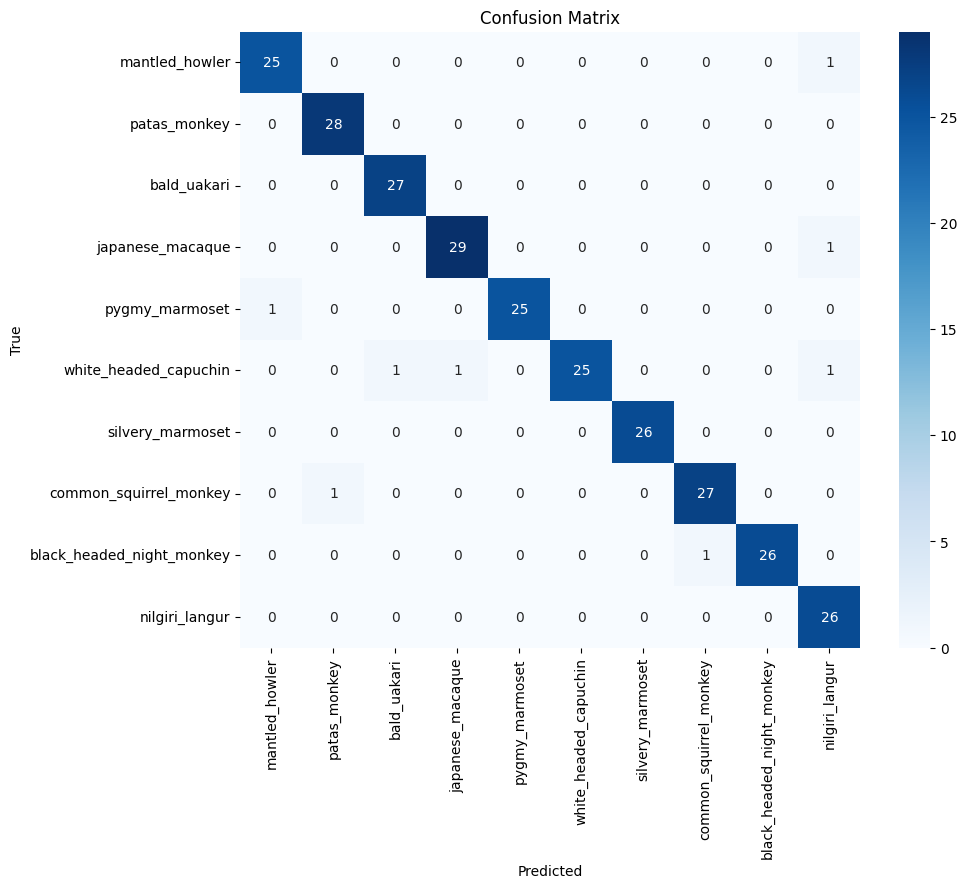

In [39]:
cm = confusion_matrix(val_gt_labels, pred_indices)

plt.figure(figsize=(10, 8))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_mapping.values(), yticklabels=class_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()